# Explain tensorflow model using Shap and Model Weights on METABRIC data

In [669]:
from platform import python_version
python_version()

'3.8.18'

In [683]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.13.0


In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-02-19 13:40:35.802602: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-02-19 13:40:35.802618: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2024-02-19 13:40:35.802622: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2024-02-19 13:40:35.802646: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-19 13:40:35.802662: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


True

# Data load and preprocessing 

## Expression data

In [4]:
df = pd.read_csv("/Users/lamine/Explainqble AI /metabric_test.csv")
df.head(5)

,CD52,DARC,DCN,DB005376,TAT,GSTM1,UGT2B11,AKR7A3,SERHL2,ASS1,...,MYB,PROM1,GSTT1,NELL2,CST5,CCL5,TFF3,CDH3,SLC39A6,SHISA2
0,8.240128,10.731211,11.251592,5.350604,5.698745,5.626606,5.845062,8.334491,7.150713,9.887783,...,7.864506,10.475799,5.236212,6.462909,5.333817,8.771015,10.545305,8.588759,8.287300,6.155340
1,7.441887,6.498731,9.968656,5.701508,5.416231,5.108180,5.382890,10.277779,6.070879,6.203103,...,10.699097,5.977531,8.450049,7.486917,5.464502,8.216436,10.422146,5.838056,10.380559,9.409817
2,7.977708,6.615727,9.632207,6.346358,5.480066,5.356168,7.798285,9.117568,6.230590,7.928613,...,9.861437,8.517411,7.230715,11.957439,5.359362,8.012079,12.201802,6.681570,10.009376,9.094121
3,8.045781,5.806614,8.927632,5.628718,5.746114,5.402901,6.043053,10.057702,11.682904,10.047193,...,9.138474,9.099391,8.072639,12.478907,5.523048,9.245577,14.169804,6.392376,11.141299,10.039994
4,9.001653,7.928994,9.356798,5.484226,5.152513,5.401268,8.511554,11.127156,7.472530,7.200276,...,9.591358,7.264378,8.975517,10.044922,5.034380,10.243518,13.568835,8.476834,8.916101,5.929184


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1897 entries, 0 to 1896
Columns: 295 entries, CD52 to SHISA2
dtypes: float64(295)
memory usage: 4.3 MB


In [6]:
df.describe()

,CD52,DARC,DCN,DB005376,TAT,GSTM1,UGT2B11,AKR7A3,SERHL2,ASS1,...,MYB,PROM1,GSTT1,NELL2,CST5,CCL5,TFF3,CDH3,SLC39A6,SHISA2
count,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,...,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000,1897.000000
mean,8.522002,7.439279,8.592254,6.084079,6.267616,6.477882,6.920908,9.397352,7.558455,8.298495,...,9.743111,8.041666,8.295523,7.466347,6.033271,9.845330,11.742209,7.465389,9.204424,7.725656
std,1.349624,1.323882,1.366120,1.489150,1.623607,1.490238,2.132190,1.280389,1.724598,1.314099,...,1.242550,1.996117,1.691650,1.532031,1.500256,1.357065,2.444823,1.274105,1.620264,1.659966
min,5.018810,5.099984,5.074217,4.922326,4.925973,4.939510,4.988302,6.888636,5.214098,5.001618,...,5.565536,5.047322,4.854543,5.030010,4.965204,5.685101,5.154748,5.103031,5.510203,5.119337
25%,7.526147,6.337077,7.585572,5.315275,5.400663,5.428807,5.547688,8.359180,6.265815,7.277712,...,9.072006,6.297426,7.469392,6.264153,5.337878,8.875585,10.657896,6.461509,7.869267,6.363869
50%,8.448275,7.331663,8.608817,5.461374,5.563156,5.624529,5.881415,9.331409,7.083379,8.280220,...,10.023695,7.623121,8.889979,7.056264,5.484401,9.857851,12.473404,7.303850,9.201048,7.358426
75%,9.428863,8.370030,9.566763,5.971988,6.175448,7.490048,7.556015,10.241203,8.371308,9.256413,...,10.654395,9.607842,9.489065,8.371956,5.818663,10.791775,13.588736,8.255375,10.508201,8.869039
max,13.374739,11.619202,12.478475,13.010996,13.166804,12.070735,14.145451,13.512971,13.731721,12.182876,...,12.091906,13.569006,12.784519,13.110442,13.922840,14.004198,14.808641,12.003642,13.440167,12.874823


## label data 

In [7]:
metadata = pd.read_csv("/Users/lamine/Explainqble AI /metabric_clin.csv")
metadata.head(5)

,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,COHORT,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,...,OS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,VITAL_STATUS,LATERALITY,RADIO_THERAPY,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY,RFS_STATUS,RFS_MONTHS
0,MB-0000,10.0,6.044,NaN,NO,1.0,Positve,NEUTRAL,YES,Post,...,0:LIVING,claudin-low,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY,0:Not Recurred,138.65
1,MB-0002,0.0,4.020,High,NO,1.0,Positve,NEUTRAL,YES,Pre,...,0:LIVING,LumA,ER+/HER2- High Prolif,Living,Right,YES,Ductal/NST,BREAST CONSERVING,0:Not Recurred,83.52
2,MB-0005,1.0,4.030,High,YES,1.0,Positve,NEUTRAL,YES,Pre,...,1:DECEASED,LumB,NaN,Died of Disease,Right,NO,Ductal/NST,MASTECTOMY,1:Recurred,151.28
3,MB-0006,3.0,4.050,Moderate,YES,1.0,Positve,NEUTRAL,YES,Pre,...,0:LIVING,LumB,NaN,Living,Right,YES,Mixed,MASTECTOMY,0:Not Recurred,162.76
4,MB-0008,8.0,6.080,High,YES,1.0,Positve,NEUTRAL,YES,Post,...,1:DECEASED,LumB,ER+/HER2- High Prolif,Died of Disease,Right,YES,Mixed,MASTECTOMY,1:Recurred,18.55


In [8]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1897 entries, 0 to 1896
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   PATIENT_ID                     1897 non-null   object 
 1   LYMPH_NODES_EXAMINED_POSITIVE  1897 non-null   float64
 2   NPI                            1897 non-null   float64
 3   CELLULARITY                    1843 non-null   object 
 4   CHEMOTHERAPY                   1897 non-null   object 
 5   COHORT                         1897 non-null   float64
 6   ER_IHC                         1867 non-null   object 
 7   HER2_SNP6                      1897 non-null   object 
 8   HORMONE_THERAPY                1897 non-null   object 
 9   INFERRED_MENOPAUSAL_STATE      1897 non-null   object 
 10  SEX                            1897 non-null   object 
 11  INTCLUST                       1897 non-null   object 
 12  AGE_AT_DIAGNOSIS               1897 non-null   f

In [9]:
metadata.columns

Index(['PATIENT_ID', 'LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'CELLULARITY',
       'CHEMOTHERAPY', 'COHORT', 'ER_IHC', 'HER2_SNP6', 'HORMONE_THERAPY',
       'INFERRED_MENOPAUSAL_STATE', 'SEX', 'INTCLUST', 'AGE_AT_DIAGNOSIS',
       'OS_MONTHS', 'OS_STATUS', 'CLAUDIN_SUBTYPE', 'THREEGENE',
       'VITAL_STATUS', 'LATERALITY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE',
       'BREAST_SURGERY', 'RFS_STATUS', 'RFS_MONTHS'],
      dtype='object')

In [10]:
print(f"The total patient ids are {metadata['PATIENT_ID'].count()}, from those the unique ids are {metadata['PATIENT_ID'].value_counts().shape[0]} ")

The total patient ids are 1897, from those the unique ids are 1897 


In [11]:
columns = metadata.keys()
columns = list(columns)
print(columns)

['PATIENT_ID', 'LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'CELLULARITY', 'CHEMOTHERAPY', 'COHORT', 'ER_IHC', 'HER2_SNP6', 'HORMONE_THERAPY', 'INFERRED_MENOPAUSAL_STATE', 'SEX', 'INTCLUST', 'AGE_AT_DIAGNOSIS', 'OS_MONTHS', 'OS_STATUS', 'CLAUDIN_SUBTYPE', 'THREEGENE', 'VITAL_STATUS', 'LATERALITY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE', 'BREAST_SURGERY', 'RFS_STATUS', 'RFS_MONTHS']


In [12]:
# Remove unnecesary elements
columns.remove('PATIENT_ID')
# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

There are 23 columns of labels for these conditions: ['LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'CELLULARITY', 'CHEMOTHERAPY', 'COHORT', 'ER_IHC', 'HER2_SNP6', 'HORMONE_THERAPY', 'INFERRED_MENOPAUSAL_STATE', 'SEX', 'INTCLUST', 'AGE_AT_DIAGNOSIS', 'OS_MONTHS', 'OS_STATUS', 'CLAUDIN_SUBTYPE', 'THREEGENE', 'VITAL_STATUS', 'LATERALITY', 'RADIO_THERAPY', 'HISTOLOGICAL_SUBTYPE', 'BREAST_SURGERY', 'RFS_STATUS', 'RFS_MONTHS']


In [13]:
metadata['THREEGENE'].unique()

array(['ER-/HER2-', 'ER+/HER2- High Prolif', nan, 'ER+/HER2- Low Prolif',
       'HER2+'], dtype=object)

In [14]:
print(f"The total patient ids are {metadata['PATIENT_ID'].count()}, from those the unique ids CHEMOTHERAPY are {metadata['CHEMOTHERAPY'].value_counts().shape[0]} ")

The total patient ids are 1897, from those the unique ids CHEMOTHERAPY are 2 


In [15]:
print(f'Number of patient ER-/HER2- :%i'  %metadata[metadata['THREEGENE']=='ER-/HER2-'].count()[0])
print(f'Number of patient ER+/HER2- High Prolif :%i'  %metadata[metadata['THREEGENE']=='ER+/HER2- High Prolif'].count()[0])
print(f'Number of patient ER+/HER2- Low Prolif :%i'  %metadata[metadata['THREEGENE']=='ER+/HER2- Low Prolif'].count()[0])
print(f'Number of patient HER2+ :%i'  %metadata[metadata['THREEGENE']=='HER2+'].count()[0])
print(f'Number of patient nan :%i'  %metadata[metadata['THREEGENE']=='nan'].count()[0])

Number of patient ER-/HER2- :290
Number of patient ER+/HER2- High Prolif :598
Number of patient ER+/HER2- Low Prolif :618
Number of patient HER2+ :188
Number of patient nan :0


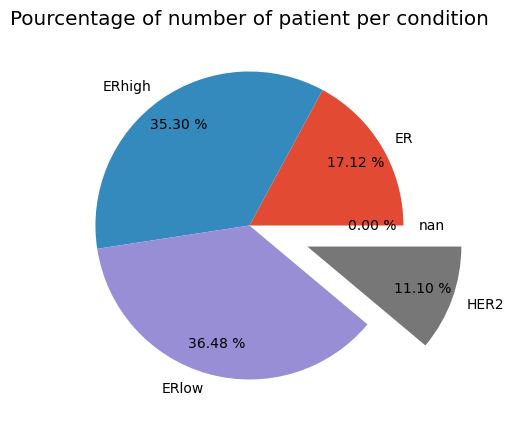

In [16]:
plt.figure(figsize=(8,5), dpi=100)

plt.style.use('ggplot')

ER = metadata[metadata['THREEGENE']=='ER-/HER2-'].count()[0]
ERhigh = metadata[metadata['THREEGENE']=='ER+/HER2- High Prolif'].count()[0]
ERlow = metadata[metadata['THREEGENE']=='ER+/HER2- Low Prolif'].count()[0]
HER2 = metadata[metadata['THREEGENE']=='HER2+'].count()[0]
nan = metadata[metadata['THREEGENE']=='nan'].count()[0]


Condition = [ER, ERhigh, ERlow, HER2, nan]
label = ['ER', 'ERhigh', 'ERlow', 'HER2', 'nan']
explode = (0,0,0,.4,0)

plt.title('Pourcentage of number of patient per condition')

plt.pie(Condition, labels=label, explode=explode, pctdistance=0.8,autopct='%.2f %%')
plt.show()

In [17]:
print(f'Number of patient CHEMOTHERAPY Yes :%i'  %metadata[metadata['CHEMOTHERAPY']=='YES'].count()[0])
print(f'Number of patient CHEMOTHERAPY NO :%i'  %metadata[metadata['CHEMOTHERAPY']=='NO'].count()[0])


Number of patient CHEMOTHERAPY Yes :396
Number of patient CHEMOTHERAPY NO :1501


In [18]:
Outcome = pd.DataFrame(metadata['CHEMOTHERAPY'])
Outcome.head()

,CHEMOTHERAPY
0,NO
1,NO
2,YES
3,YES
4,YES


In [19]:
Outcome = Outcome.replace("YES",1)
Outcome = Outcome.replace("NO",0)
Outcome.head()

,CHEMOTHERAPY
0,0
1,0
2,1
3,1
4,1


In [20]:
print('Labels counts in Outcome Yes and No respectively:', np.bincount(Outcome['CHEMOTHERAPY']))

Labels counts in Outcome Yes and No respectively: [1501  396]


here we clearly dealing with class imbalance.

In [21]:
df.index = metadata['PATIENT_ID']
Outcome.index = metadata['PATIENT_ID']

In [22]:
Outcome = Outcome[Outcome.index.isin(df.index)]
Outcome.head()

,CHEMOTHERAPY
PATIENT_ID,
MB-0000,0
MB-0002,0
MB-0005,1
MB-0006,1
MB-0008,1


here we clearly dealing with class imbalance.
### Class imbalance correct using imblearn

In [23]:
#!pip install -U imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [24]:
ros = RandomOverSampler(random_state=0)
df_resampled, Outcome_resampled = ros.fit_resample(df, Outcome['CHEMOTHERAPY'])

In [25]:
from collections import Counter
print(sorted(Counter(Outcome_resampled).items()))

[(0, 1501), (1, 1501)]


In [26]:
print('Labels counts in Outcome are now:', np.bincount(Outcome_resampled))

Labels counts in Outcome are now: [1501 1501]


## Data preparation for deep learning model

In [27]:
df_resampled = df_resampled.astype('float32')
Outcome_resampled = Outcome_resampled.astype('float32')

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(df_resampled, Outcome_resampled,
                                                    test_size=0.3, random_state=42, shuffle=True)

In [56]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_train.dtypes = {X_train.dtypes}")

X_train.shape = (2101, 295)
X_train.dtypes = CD52        float32
DARC        float32
DCN         float32
DB005376    float32
TAT         float32
             ...   
CCL5        float32
TFF3        float32
CDH3        float32
SLC39A6     float32
SHISA2      float32
Length: 295, dtype: object


In [74]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, 
                                                  shuffle=True)

In [75]:
scaler  = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)   
x_test_scaled = scaler.transform(X_test)

In [76]:
print(f"x_train_scaled.shape = {x_train_scaled.shape}")
print(f"x_val_scaled.shape = {x_val_scaled.shape}")
print(f"x_test_scaled.shape = {x_test_scaled.shape}")

x_train_scaled.shape = (1575, 295)
x_val_scaled.shape = (526, 295)
x_test_scaled.shape = (901, 295)


In [171]:
# y_train = np.asarray(Y_train).astype('float32').reshape((-1,1))

# Model

In [670]:
EPOCHS = 50
NB_CLASSES = 1   
DROPOUT = 0.3

In [570]:
# The model hyperparatmeter was defined with gridSearchCV using scikeras.wrappers below.
model = Sequential()
model.add(Dense(10, input_shape=x_train_scaled.shape[1:], activation = 'relu', name='dense_layer'))
model.add(Dropout(DROPOUT))
model.add(Dense(10, activation = 'relu', name='dense_layer_2'))
model.add(Dropout(DROPOUT))
model.add(Dense(NB_CLASSES, activation= "sigmoid", name='dense_layer_4'))                              

In [671]:
model.summary()

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer (Dense)         (None, 10)                2960      
                                                                 
 dropout_56 (Dropout)        (None, 10)                0         
                                                                 
 dense_layer_2 (Dense)       (None, 10)                110       
                                                                 
 dropout_57 (Dropout)        (None, 10)                0         
                                                                 
 dense_layer_4 (Dense)       (None, 1)                 11        
                                                                 
Total params: 3081 (12.04 KB)
Trainable params: 3081 (12.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


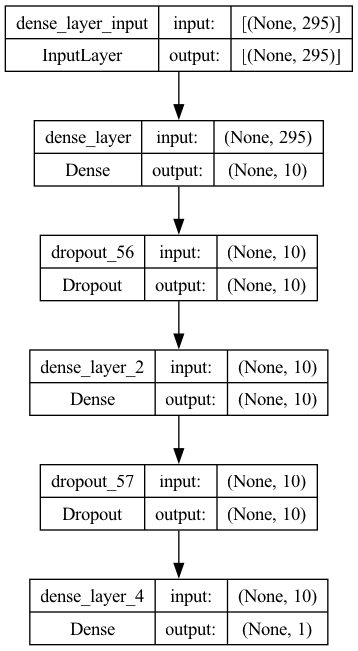

In [672]:
keras.utils.plot_model(model, show_shapes=True)

In [160]:
early_stopping = EarlyStopping(
    patience  = 10,     # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [571]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

In [572]:
#training the moodel
results = model.fit(x_train_scaled, y_train, epochs=EPOCHS, 
                    verbose=1, callbacks=[early_stopping],
                   validation_data=(x_val_scaled, y_val))

Epoch 1/50


2024-02-20 12:33:46.256299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.5829

2024-02-20 12:33:47.283473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 2s 21ms/step - loss: 0.6839 - accuracy: 0.5829 - val_loss: 0.5990 - val_accuracy: 0.6768
Epoch 2/50
50/50 [==============================] - 0s 8ms/step - loss: 0.6034 - accuracy: 0.6819 - val_loss: 0.5764 - val_accuracy: 0.6977
Epoch 3/50
50/50 [==============================] - 0s 7ms/step - loss: 0.6008 - accuracy: 0.6832 - val_loss: 0.5729 - val_accuracy: 0.6996
Epoch 4/50
50/50 [==============================] - 0s 7ms/step - loss: 0.5981 - accuracy: 0.6902 - val_loss: 0.5348 - val_accuracy: 0.7643
Epoch 5/50
50/50 [==============================] - 0s 8ms/step - loss: 0.5814 - accuracy: 0.6952 - val_loss: 0.5215 - val_accuracy: 0.7586
Epoch 6/50
50/50 [==============================] - 0s 7ms/step - loss: 0.5875 - accuracy: 0.7079 - val_loss: 0.5359 - val_accuracy: 0.7510
Epoch 7/50
50/50 [==============================] - 0s 8ms/step - loss: 0.5721 - accuracy: 0.7130 - val_loss: 0.5277 - val_accuracy: 0.7624
Epoch 8/50
50/50 [============

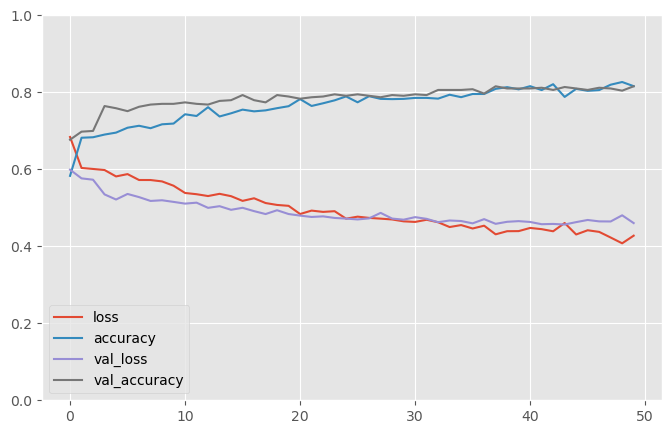

In [573]:
pd.DataFrame(results.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [574]:
#evalute the model
test_loss, test_acc = model.evaluate(x_test_scaled, Y_test)
print('Test accuracy:', test_acc)

29/29 [==============================] - 0s 5ms/step - loss: 0.4471 - accuracy: 0.8069
Test accuracy: 0.8068812489509583


In [663]:
# making prediction
predictions = model.predict(X_test)

29/29 [==============================] - 0s 1ms/step


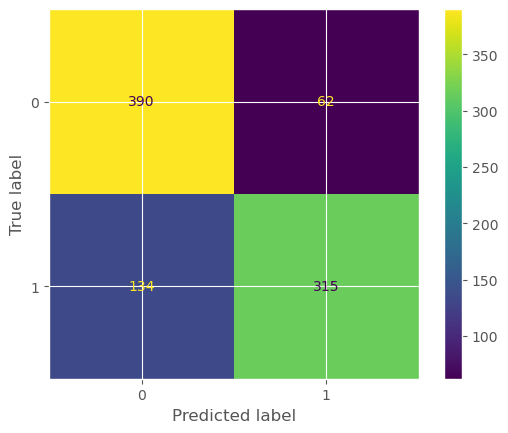

In [576]:
predicted = tf.squeeze(predictions)
predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
actual = np.array(Y_test)
conf_mat = confusion_matrix(actual, predicted)
displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
displ.plot()

# Explainability 

## Explain tensorflow keras model with shap DeepExplainer

In [578]:
sample_size=500
if sample_size>len(X_train.values):
  sample_size=len(X_train.values)

explainer = shap.DeepExplainer(model, X_train.values[:sample_size], y_train)

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [580]:
# Explain the SHAP values for the whole dataset
# to test the SHAP explainer.
shap_values = explainer.shap_values(X_train.values[:sample_size], ranked_outputs=None)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
2024-02-20 12:35:40.755383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [675]:
shap_values

[array([[-1.28761018e-02,  2.61684251e-03,  1.22101256e-03, ...,
          8.43746180e-04, -1.53695641e-03,  6.51940797e-03],
        [ 7.81806372e-03,  4.66133794e-03, -3.80936824e-02, ...,
         -3.02560464e-03, -3.34495748e-03,  2.56811804e-03],
        [ 4.50713374e-03, -5.79754077e-03,  1.47271063e-02, ...,
          3.39945336e-03,  4.03275434e-03, -4.77008102e-03],
        ...,
        [-3.10847047e-03,  3.97476554e-03, -1.40036177e-02, ...,
          1.44137791e-03,  7.17193168e-03,  2.29408732e-03],
        [ 1.69399404e-03,  1.97411259e-03,  1.24843428e-02, ...,
         -1.57582830e-03, -2.14419863e-03,  7.04625854e-05],
        [-7.05904374e-03,  2.57816073e-03, -1.22835450e-02, ...,
         -3.26953549e-03, -1.49948173e-03,  3.01212166e-03]])]

In [684]:
# #shap_values 
# shap.initjs()
# shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0], X_train, link="logit")

In [634]:
def get_fetaure_importnace(shap_values, features):
    "Features is the  X_train.columns names"
    vals = np.abs(pd.DataFrame(shap_values[0]).values).mean(0)
    shap_importance = pd.DataFrame(list(zip(features, vals)), columns=['col_name', 'feature_importance_vals'])
    shap_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
    shap_importance.loc[shap_importance['feature_importance_vals']>0]
    return shap_importance

In [637]:
shap_importance = get_fetaure_importnace(shap_values, features=X_train.columns)
shap_importance

,col_name,feature_importance_vals
131,ESR1,0.084175
245,BEX1,0.031682
279,FOSB,0.029250
110,IGJ,0.029118
271,FABP7,0.027046
...,...,...
4,TAT,0.000288
241,CHGB,0.000264
152,FOLR1,0.000237
198,PVALB,0.000217


In [657]:
def plot_importance_features(Features, top=10, title=" "):
    " Features is a 2 colunm dataframe with features names and weights"
    
    fig, ax = plt.subplots(figsize =(5, 5))
    top_features = Features.iloc[:top]
    # Horizontal Bar Plot
    ax.barh(top_features['col_name'], top_features['feature_importance_vals'])
    ax.set_yticks(top_features['col_name'])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Importance')
    ax.set_title(title)
    plot = plt.show()
    return plot

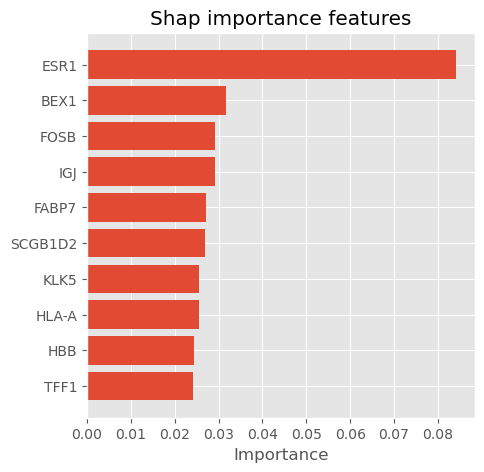

In [659]:
plot_importance_features(Features=shap_importance, top=10, title="Shap importance features")

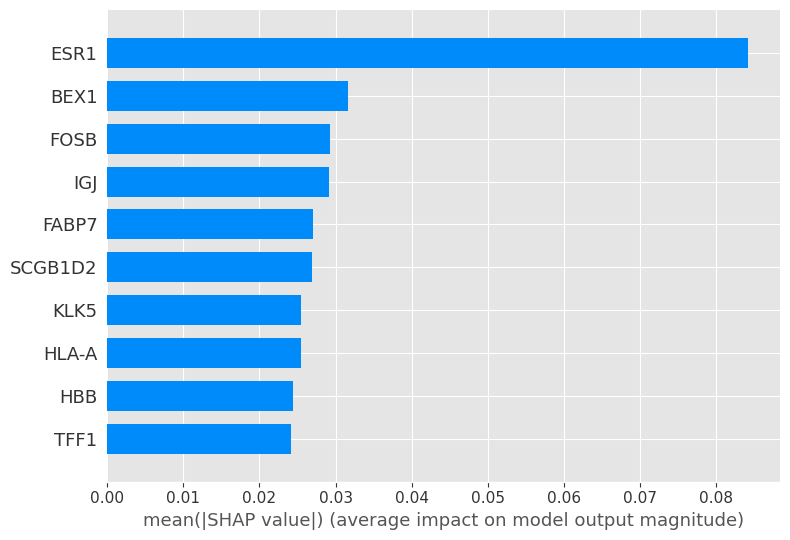

In [676]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.summary_plot(shap_values[0], X_test, plot_type="bar", max_display=10)

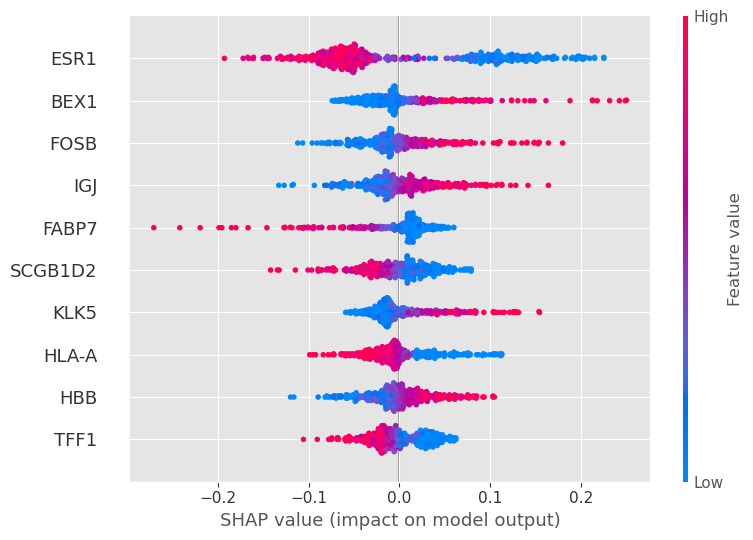

In [625]:
shap.summary_plot(shap_values[0], features=X_train.values[:sample_size], feature_names=features, show=False, plot_type="dot", max_display=10)

## Explain tensorflow keras model with weights

In [653]:
def get_weights_importnace(model, features, num=0):
    "Features is the  X_train.columns names"
    vals_weights = np.abs(model.layers[num].get_weights()[num].T).mean(num)
    weights_importance = pd.DataFrame(list(zip(features, vals_weights)), columns=['col_name', 'feature_importance_vals'])
    weights_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
    weights_importance.loc[weights_importance['feature_importance_vals']>0] 
    return weights_importance

In [654]:
weights_importance =  get_weights_importnace(model, features= X_train.columns)
weights_importance

,col_name,feature_importance_vals
131,ESR1,0.190406
16,AGTR1,0.136717
182,DCD,0.136054
121,KLK5,0.135646
110,IGJ,0.134122
...,...,...
212,PRODH,0.045159
194,AKR1C2,0.044727
176,ACTG2,0.044115
91,SLPI,0.042295


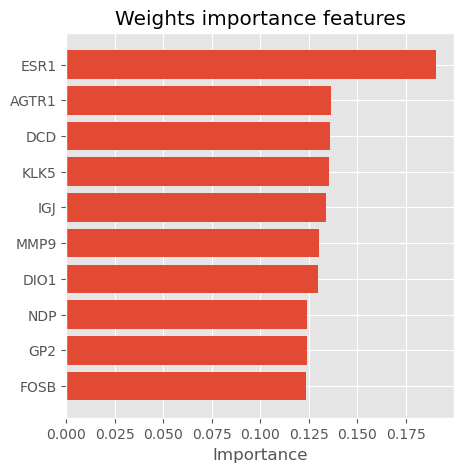

In [665]:
plot_importance_features(Features=weights_importance, top=10, title="Weights importance features")

# Hyperparameter tunning with GridSearchCV using scikeras.wrappers

In [116]:

def get_model(nb_hidden, nb_neurons):
    print(f"##  {nb_hidden}-{nb_neurons}   ##")
    model = keras.models.Sequential()
    model.add(Dense(64, input_shape=x_train_scaled.shape[1:], activation = 'relu', name='dense_layer'))
    model.add(keras.layers.Dense(2 * nb_neurons, activation="relu"))    
    if nb_hidden > 1 :
        for layer in range(2, nb_hidden):
            model.add(keras.layers.Dense(nb_neurons, activation="relu"))
    model.add(keras.layers.Dense(1, activation="sigmoid" ))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    return model


In [114]:
#!pip install scikeras
from scikeras.wrappers import KerasClassifier 

In [168]:
keras_classifier = KerasClassifier(get_model, nb_hidden=1, nb_neurons=1)


param_distribs = {
"nb_hidden": [1,2,3,6,8],
"nb_neurons": [3,5,8,10],
}



early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

search_cv = GridSearchCV(keras_classifier, param_distribs,  cv=2 )
search_cv.fit(x_train_scaled, y_train, epochs=20,  callbacks=[early_stopping], validation_data=[x_val_scaled, y_val],  )

print(f"search_cv.best_params_ = {search_cv.best_params_}")

print(f"search_cv.best_score_ = {search_cv.best_score_}") 

In [169]:
print(f"search_cv.best_params_ = {search_cv.best_params_}")

print(f"search_cv.best_score_ = {search_cv.best_score_}") 

search_cv.best_params_ = {'nb_hidden': 1, 'nb_neurons': 10}
search_cv.best_score_ = 0.810161475499713
